🌾 Agricultural Price & Demand Prediction Model
📊 Loading dataset...
Dataset shape: (100000, 12)
Columns: ['Date', 'Crop', 'District', 'DayOfWeek', 'Weather', 'Supply', 'Prev_Price', 'Prev_Demand', 'Festival_Week', 'Retail_Price', 'Price', 'Demand']

📈 Dataset Overview:
                             Date        Supply     Prev_Price    Prev_Demand  \
count                      100000  100000.00000  100000.000000  100000.000000   
mean   2023-07-02 08:39:39.168000     748.37186     129.255430     598.928460   
min           2022-01-01 00:00:00     300.00000      60.000000     200.000000   
25%           2022-10-01 00:00:00     523.00000      94.000000     399.000000   
50%           2023-07-03 00:00:00     748.00000     129.000000     598.000000   
75%           2024-04-01 00:00:00     974.00000     164.000000     800.000000   
max           2024-12-31 00:00:00    1199.00000     199.000000     999.000000   
std                           NaN     259.65443      40.399087     231.072787   



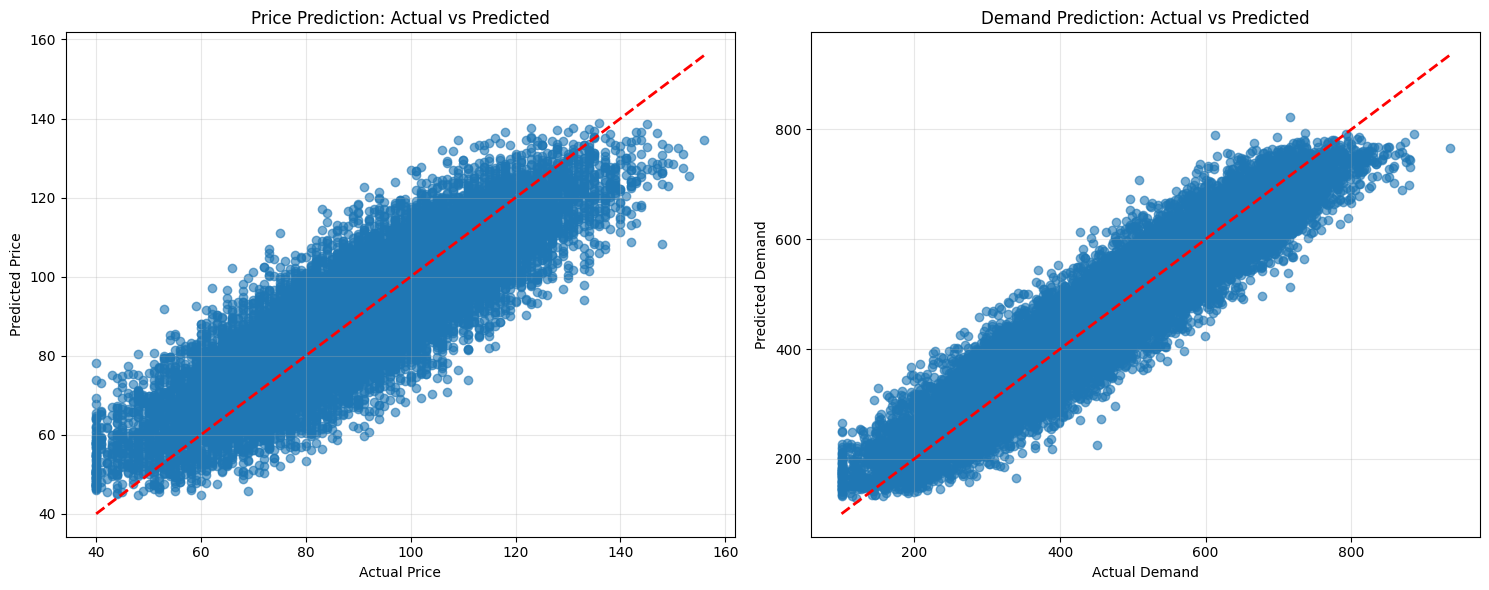


🔍 Top 10 Most Important Features:
          Feature  Importance
18    Prev_Demand    0.332202
16         Supply    0.321251
17     Prev_Price    0.217253
20   Retail_Price    0.074086
23            Day    0.014342
21          Month    0.010389
22           Year    0.003811
14  Weather_Rainy    0.001981
15  Weather_Sunny    0.001913
1      Crop_Onion    0.001646

💾 Model saved to: agricultural_prediction_model_20250702_114623.joblib

🎉 Model training and evaluation completed successfully!

🔮 Example Prediction:
Predicted Price: Rs. 88.94/kg
Predicted Demand: 348 kg


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

class AgriculturalPredictionModel:
    def __init__(self):
        self.model = None
        self.preprocessor = None
        self.feature_names = None
        self.target_names = ['Price', 'Demand']
        
    def load_and_preprocess_data(self, file_path):
        """Load and preprocess the agricultural dataset"""
        print("📊 Loading dataset...")
        df = pd.read_csv(file_path)
        print(f"Dataset shape: {df.shape}")
        print(f"Columns: {list(df.columns)}")
        
        # Convert Date to datetime and extract additional features
        df['Date'] = pd.to_datetime(df['Date'])
        df['Month'] = df['Date'].dt.month
        df['Year'] = df['Date'].dt.year
        df['Day'] = df['Date'].dt.day
        
        # Display basic statistics
        print("\n📈 Dataset Overview:")
        print(df.describe())
        
        # Check for missing values
        print("\n🔍 Missing Values:")
        print(df.isnull().sum())
        
        return df
    
    def prepare_features_and_targets(self, df):
        """Prepare features and target variables"""
        # Define feature columns
        categorical_features = ['Crop', 'District', 'DayOfWeek', 'Weather']
        numerical_features = ['Supply', 'Prev_Price', 'Prev_Demand', 'Festival_Week', 
                            'Retail_Price', 'Month', 'Year', 'Day']
        
        # Features (X) and targets (y)
        X = df[categorical_features + numerical_features].copy()
        y = df[['Price', 'Demand']].copy()
        
        self.feature_names = categorical_features + numerical_features
        
        print(f"\n🎯 Features: {self.feature_names}")
        print(f"📊 Target variables: {self.target_names}")
        print(f"Feature matrix shape: {X.shape}")
        print(f"Target matrix shape: {y.shape}")
        
        return X, y, categorical_features, numerical_features
    
    def create_preprocessor(self, categorical_features, numerical_features):
        """Create preprocessing pipeline"""
        # Create preprocessing steps
        preprocessor = ColumnTransformer(
            transformers=[
                ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features),
                ('num', StandardScaler(), numerical_features)
            ],
            remainder='passthrough'
        )
        
        self.preprocessor = preprocessor
        return preprocessor
    
    def train_model(self, X_train, y_train):
        """Train the multi-output regression model"""
        print("\n🚀 Training multi-output regression model...")
        
        # Use RandomForestRegressor with MultiOutputRegressor
        base_model = RandomForestRegressor(
            n_estimators=100,
            max_depth=15,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42,
            n_jobs=-1
        )
        
        # Multi-output wrapper
        self.model = MultiOutputRegressor(base_model)
        
        # Fit preprocessor and model
        X_train_processed = self.preprocessor.fit_transform(X_train)
        self.model.fit(X_train_processed, y_train)
        
        print("✅ Model training completed!")
        
    def evaluate_model(self, X_test, y_test):
        """Evaluate model performance"""
        print("\n📊 Evaluating model performance...")
        
        # Make predictions
        X_test_processed = self.preprocessor.transform(X_test)
        y_pred = self.model.predict(X_test_processed)
        
        # Calculate metrics for each target
        results = {}
        for i, target in enumerate(self.target_names):
            mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
            rmse = np.sqrt(mean_squared_error(y_test.iloc[:, i], y_pred[:, i]))
            r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
            
            results[target] = {
                'MAE': mae,
                'RMSE': rmse,
                'R2': r2
            }
            
            print(f"\n{target} Prediction Metrics:")
            print(f"  MAE:  {mae:.2f}")
            print(f"  RMSE: {rmse:.2f}")
            print(f"  R²:   {r2:.4f}")
        
        return results, y_pred
    
    def plot_predictions(self, y_test, y_pred):
        """Plot actual vs predicted values"""
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        for i, target in enumerate(self.target_names):
            axes[i].scatter(y_test.iloc[:, i], y_pred[:, i], alpha=0.6)
            axes[i].plot([y_test.iloc[:, i].min(), y_test.iloc[:, i].max()], 
                        [y_test.iloc[:, i].min(), y_test.iloc[:, i].max()], 
                        'r--', lw=2)
            axes[i].set_xlabel(f'Actual {target}')
            axes[i].set_ylabel(f'Predicted {target}')
            axes[i].set_title(f'{target} Prediction: Actual vs Predicted')
            axes[i].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def get_feature_importance(self):
        """Get and display feature importance"""
        if hasattr(self.model.estimators_[0], 'feature_importances_'):
            # Get feature names after preprocessing
            cat_features = self.preprocessor.named_transformers_['cat'].get_feature_names_out()
            num_features = self.preprocessor.named_transformers_['num'].get_feature_names_out()
            all_features = list(cat_features) + list(num_features)
            
            # Average importance across both target models
            importance_price = self.model.estimators_[0].feature_importances_
            importance_demand = self.model.estimators_[1].feature_importances_
            avg_importance = (importance_price + importance_demand) / 2
            
            # Create importance dataframe
            importance_df = pd.DataFrame({
                'Feature': all_features,
                'Importance': avg_importance
            }).sort_values('Importance', ascending=False)
            
            print("\n🔍 Top 10 Most Important Features:")
            print(importance_df.head(10))
            
            return importance_df
    
    def save_model(self, filepath):
        """Save the trained model and preprocessor"""
        model_data = {
            'model': self.model,
            'preprocessor': self.preprocessor,
            'feature_names': self.feature_names,
            'target_names': self.target_names
        }
        joblib.dump(model_data, filepath)
        print(f"\n💾 Model saved to: {filepath}")
    
    def load_model(self, filepath):
        """Load a pre-trained model"""
        model_data = joblib.load(filepath)
        self.model = model_data['model']
        self.preprocessor = model_data['preprocessor']
        self.feature_names = model_data['feature_names']
        self.target_names = model_data['target_names']
        print(f"📂 Model loaded from: {filepath}")
    
    def predict(self, X_new):
        """Make predictions on new data"""
        if self.model is None or self.preprocessor is None:
            raise ValueError("Model not trained or loaded!")
        
        X_processed = self.preprocessor.transform(X_new)
        predictions = self.model.predict(X_processed)
        
        return pd.DataFrame(predictions, columns=self.target_names)

def main():
    """Main execution function"""
    print("🌾 Agricultural Price & Demand Prediction Model")
    print("=" * 50)
    
    # Initialize model
    agri_model = AgriculturalPredictionModel()
    
    # Load and preprocess data
    df = agri_model.load_and_preprocess_data('agri_price_demand_data.csv')
    
    # Prepare features and targets
    X, y, cat_features, num_features = agri_model.prepare_features_and_targets(df)
    
    # Create preprocessor
    preprocessor = agri_model.create_preprocessor(cat_features, num_features)
    
    # Split data
    print("\n📊 Splitting data (80% train, 20% test)...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=X['Crop']
    )
    
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Testing set: {X_test.shape[0]} samples")
    
    # Train model
    agri_model.train_model(X_train, y_train)
    
    # Evaluate model
    results, y_pred = agri_model.evaluate_model(X_test, y_test)
    
    # Plot results
    agri_model.plot_predictions(y_test, y_pred)
    
    # Feature importance
    importance_df = agri_model.get_feature_importance()
    
    # Save model
    model_filename = f"agricultural_prediction_model_{datetime.now().strftime('%Y%m%d_%H%M%S')}.joblib"
    agri_model.save_model(model_filename)
    
    print("\n🎉 Model training and evaluation completed successfully!")
    
    # Example prediction
    print("\n🔮 Example Prediction:")
    sample_data = pd.DataFrame({
        'Crop': ['Onion'],
        'District': ['Colombo'],
        'DayOfWeek': ['Monday'],
        'Weather': ['Sunny'],
        'Supply': [800],
        'Prev_Price': [120],
        'Prev_Demand': [400],
        'Festival_Week': [0],
        'Retail_Price': [150],
        'Month': [6],
        'Year': [2024],
        'Day': [15]
    })
    
    prediction = agri_model.predict(sample_data)
    print(f"Predicted Price: Rs. {prediction['Price'].iloc[0]:.2f}/kg")
    print(f"Predicted Demand: {prediction['Demand'].iloc[0]:.0f} kg")
    
    return agri_model

# Alternative XGBoost implementation
def train_xgboost_model():
    """Alternative implementation using XGBoost"""
    try:
        import xgboost as xgb
        print("\n🚀 Training XGBoost model as alternative...")
        
        # Load data
        df = pd.read_csv('agri_price_demand_data.csv')
        
        # Simple preprocessing for XGBoost
        le_crop = LabelEncoder()
        le_district = LabelEncoder()
        le_day = LabelEncoder()
        le_weather = LabelEncoder()
        
        df['Crop_encoded'] = le_crop.fit_transform(df['Crop'])
        df['District_encoded'] = le_district.fit_transform(df['District'])
        df['DayOfWeek_encoded'] = le_day.fit_transform(df['DayOfWeek'])
        df['Weather_encoded'] = le_weather.fit_transform(df['Weather'])
        df['Month'] = pd.to_datetime(df['Date']).dt.month
        
        # Features
        feature_cols = ['Crop_encoded', 'District_encoded', 'DayOfWeek_encoded', 
                       'Weather_encoded', 'Supply', 'Prev_Price', 'Prev_Demand', 
                       'Festival_Week', 'Retail_Price', 'Month']
        
        X = df[feature_cols]
        y = df[['Price', 'Demand']]
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Train separate models for Price and Demand
        xgb_price = xgb.XGBRegressor(n_estimators=100, random_state=42)
        xgb_demand = xgb.XGBRegressor(n_estimators=100, random_state=42)
        
        xgb_price.fit(X_train, y_train['Price'])
        xgb_demand.fit(X_train, y_train['Demand'])
        
        # Predictions
        price_pred = xgb_price.predict(X_test)
        demand_pred = xgb_demand.predict(X_test)
        
        # Evaluate
        price_mae = mean_absolute_error(y_test['Price'], price_pred)
        demand_mae = mean_absolute_error(y_test['Demand'], demand_pred)
        
        print(f"XGBoost Price MAE: {price_mae:.2f}")
        print(f"XGBoost Demand MAE: {demand_mae:.2f}")
        
        # Save XGBoost models
        joblib.dump({
            'price_model': xgb_price,
            'demand_model': xgb_demand,
            'encoders': {
                'crop': le_crop,
                'district': le_district,
                'day': le_day,
                'weather': le_weather
            }
        }, 'xgboost_agricultural_model.joblib')
        
        print("XGBoost models saved!")
        
    except ImportError:
        print("XGBoost not available. Install with: pip install xgboost")

if __name__ == "__main__":
    # Run main model
    model = main()
    
    # Optionally run XGBoost alternative
    # train_xgboost_model()